# Personal Finance ML Analysis & Recommendations
### Author: Patrick Ndungutse
### Date: 2025-01-19

## Personal Finance ML-Based Recommendations

#### This notebook performs exploratory data analysis and builds ML models for:
 - Spending pattern analysis


In [31]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from typing import Set
import re
warnings.filterwarnings('ignore')

# ML libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression

# Time Series
from datetime import datetime, timedelta

# Plotting stlye and configuration using matlpotlib and seaborn 
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


In [32]:
# load data
data_path = Path(r"W:\PFRE\PFRE\data\processed\all_transactions.csv")
df = pd.read_csv(data_path)
# convert date to datetime 

df['date'] = pd.to_datetime(df['date'])

# Dataset diagnosis: Basic info
print(f"Dataset Shape: {df.shape}")
print(f"Date Rang: {df['date'].min()} to {df['date'].max()}")
print(f"\nFirst few rows")
df.head()

# Data info
print("\nDataset Info: ")
print(df.info)
print("\nMissing Values: ")
print(df.isnull().sum())
print("\nBasic Statistics: ")
df.describe()

Dataset Shape: (2435, 5)
Date Rang: 2022-05-17 00:00:00 to 2025-12-30 00:00:00

First few rows

Dataset Info: 
<bound method DataFrame.info of            date                                        description  amount  \
0    2022-05-17                       Transfer From Sav Xxxxxx0332   50.00   
1    2022-05-31  Card Purchase With Pin 05/31 Family Fare 3785 ...  -13.47   
2    2022-05-31  Card Purchase With Pin 05/30 Hy-Vee Omaha 146 ...   -4.89   
3    2022-05-31  Card Purchase 05/30 Scooters Coffee - 57 Omaha...   -7.07   
4    2022-05-31  Card Purchase With Pin 05/29 Mega Saver/Gas St...  -18.66   
...         ...                                                ...     ...   
2430 2025-12-26              O.P.P.D. Elec Bill PPD ID: 5476000369  -83.81   
2431 2025-12-26  Card Purchase With Pin 12/25 Caseys #3816 3725...  -24.59   
2432 2025-12-26  Card Purchase With Pin 12/26 Wal-Mart Super Ce... -100.59   
2433 2025-12-30  Recurring Card Purchase 12/28 Openai *Chatgpt ...  -20.00   

,date,amount,balance
count,2435,2435.000000,2435.000000
mean,2024-04-17 08:44:33.018480640,1.191823,1126.706563
min,2022-05-17 00:00:00,-11000.000000,-1098.060000
25%,2023-05-15 00:00:00,-50.000000,180.180000
50%,2024-05-28 00:00:00,-20.880000,571.140000
75%,2025-03-15 12:00:00,-5.770000,1600.425000
max,2025-12-30 00:00:00,15202.370000,15309.480000
std,NaN,574.694336,1551.870835


### Basic Statistics and Initial Analysis
Basic descriptive statistics indicate that the dataset captures typical checking account behavior characterized by frequent small debits and infrequent large credits.
Transaction amounts exhibit heavy-tailed distributions with substantial variance, making the data well-suited for anomaly detection and cash-flow volatility modeling.
Balance statistics reveal periods of elevated risk, including occasional negative balances.

In [33]:
# create a function to feature engineer
def create_features(df): 
    """create features for all models"""

    #Time bases features
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_week'] = df['date'].dt.day_of_week
    df['day_name'] = df['date'].dt.day_name()
    df['week_of_year'] = df['date'].dt.isocalendar().week
    df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
    df['quarter'] = df['date'].dt.quarter

    #Transaction Type 
    df['transaction_type'] = df['amount'].apply(lambda  x: 'income' if x >0 else 'expense')
    df['amount_abs'] = df['amount'].abs()

    #Category extraction
    # non merchant noise as appeal on statements
    BANK_NOISE_TOKENS: Set[str] = {
        "omaha", "ppd", "pin", "statement", "account", "detail", "network", "deposit",
        "deposits", "payment", "payments", "transaction", "overdraft", "error", "case", 
        "web", "funds", "total", "online"
    }
    # category keywords dictionary
    CATEGORY_KEYWORDS = {
        "Bank Fees":{"overdraft", "fee", "charge", "interest", "nsf", "penalty"},
        "Housing": {"rent", "mortgage", "lease", "property"},
        "Utilities": {"utility", "electric", "electricity", "water", "internet", "phone", "mobile", "gasbill", "bill"},
        "Gas/Fuel": {"fuel", "gas", "caseys", "shell", "exxon", "bp", "chevron"},
        "Food/Dining": {"restaurant", "cafe", "coffee", "mcdonald", "burger", "pizza", "diner", "kfc", "subway", "taco"},
        "Shopping": {"amazon", "walmart", "target", "store", "shop", "retail"},
        "Entertainment": {"netflix", "spotfy", "movie", "cinema", "subscription", "entertainment"},
        "Transfers": {"trasnfer", "zelle", "venmo", "paypal", "ach", "wire"},
        "ATM Withdrawal": {"atm", "cash", "withdrawal"}
    }
    #prioritize categories to avoid collision
    CATEGORY_PRIORITY = {
        "Bank Fees", "Housing", "Utility", "Gas/Fuel", "Food/Dining", "Entertainment", "Shopping", "Transfers", "ATM Withdrawal"
    }

    #build categorization function
    def categorize_transaction(description: str) -> str: 
        """ Categorize a bank transactioin decscription into spending category 
        Parameters: 
        Description and return categorym
        
        """
        if not isinstance(description, str) or not description.strip():
            return "Other"
        
        #Normalize text
        text = description.lower()
        text = re.sub(r"\d++", " ", text)
        text = re.sub(r"[^a-z\s]", " ", text)

        tokens = set(text.split()) - BANK_NOISE_TOKENS

        #priority base matching 
        for category in CATEGORY_PRIORITY:
            if tokens & CATEGORY_KEYWORDS.get(category, set()):
                return category
            
        return "Other"
    df["category"] = df['description'].apply(categorize_transaction)

    #rolling statistics 
    df = df.sort_values('date')
    df['rolling_7day_mean'] = df['amount'].rolling(window=7, min_periods=1).mean()
    df['rolling_30day_mean'] = df['amount'].rolling(window=30, min_periods=2).mean()
    df['rolling_7day_std'] = df['amount'].rolling(window=7, min_periods=1).std()

    return df
df = create_features(df)
print(f"\nFeatures created! New Shape: {df.shape}")
df.head()


Features created! New Shape: (2435, 19)


,date,description,amount,balance,source_file,year,month,day,day_of_week,day_name,week_of_year,is_weekend,quarter,transaction_type,amount_abs,category,rolling_7day_mean,rolling_30day_mean,rolling_7day_std
0,2022-05-17,Transfer From Sav Xxxxxx0332,50.00,50.00,20220613-statements-8997-.pdf,2022,5,17,1,Tuesday,20,0,2,income,50.00,Other,50.000000,NaN,NaN
9,2022-05-31,Card Purchase With Pin 05/29 Dollar General # ...,-7.49,185.54,20220613-statements-8997-.pdf,2022,5,31,1,Tuesday,22,0,2,expense,7.49,Other,21.255000,21.255000,40.651569
7,2022-05-31,Card Purchase 05/29 Icehouse Sports Bar Omaha ...,-40.00,210.00,20220613-statements-8997-.pdf,2022,5,31,1,Tuesday,22,0,2,expense,40.00,Other,0.836667,0.836667,45.574116
6,2022-05-31,Card Purchase 05/29 African Farms Omaha NE Car...,-16.97,193.03,20220613-statements-8997-.pdf,2022,5,31,1,Tuesday,22,0,2,expense,16.97,Other,-3.615000,-3.615000,38.261417
5,2022-05-31,Card Purchase With Pin 05/31 Mega Saver/Gas St...,-10.59,144.33,20220613-statements-8997-.pdf,2022,5,31,1,Tuesday,22,0,2,expense,10.59,Gas/Fuel,-5.010000,-5.010000,33.281859


In [34]:
# extract summary statistics 
print("\n=== SUMMARY STATISTICS ===")
expenses = df[df['amount']<0]
income = df[df['amount']>0]

summary_stats = {
    'Total Transaction': len(df),
    'Total Income': f"${income['amount'].sum():,.2f}",
    'Total Expense': f"${expenses['amount'].sum():,.2f}",
    'Net Cash Flow': f"${df['amount'].sum():,.2f}",
    'Average Transaction': f"${df['amount_abs'].mean():,.2f}",
    'Median Transaction': f"${df['amount_abs'].median():,.2f}",
    'Number of Categories': f"{df['category'].unique()}"
}
for key, value in summary_stats.items():
    print(f"{key}: {value}")


=== SUMMARY STATISTICS ===
Total Transaction: 2435
Total Income: $206,631.57
Total Expense: $-203,729.48
Net Cash Flow: $2,902.09
Average Transaction: $168.53
Median Transaction: $34.00
Number of Categories: ['Other' 'Gas/Fuel' 'ATM Withdrawal' 'Food/Dining' 'Housing' 'Transfers'
 'Shopping' 'Bank Fees' 'Entertainment']


### Summary Stats
The dataset contains 2,435 bank transactions with a total inflow of $206.6K and outflows of $203.7K, resulting in a modest positive net cash flow. Transaction values are highly skewed, with a median transaction size of $34, indicating frequent low-value spending punctuated by infrequent large transactions. Spending spans nine primary categories, supporting both behavioral analysis and supervised learning tasks.

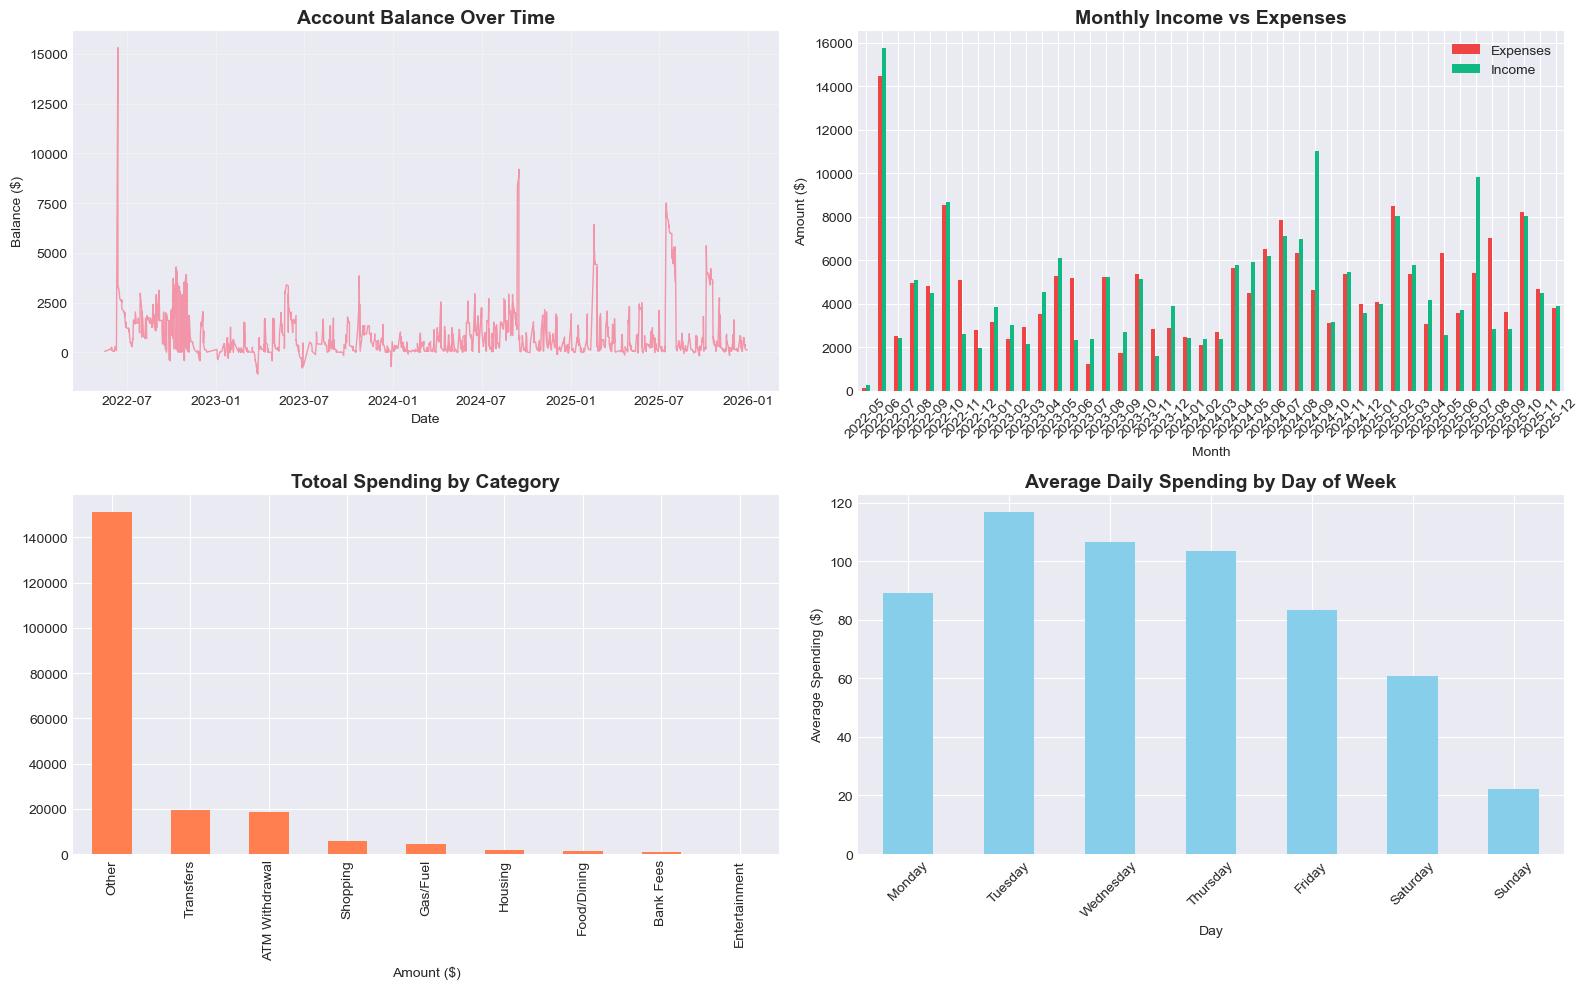

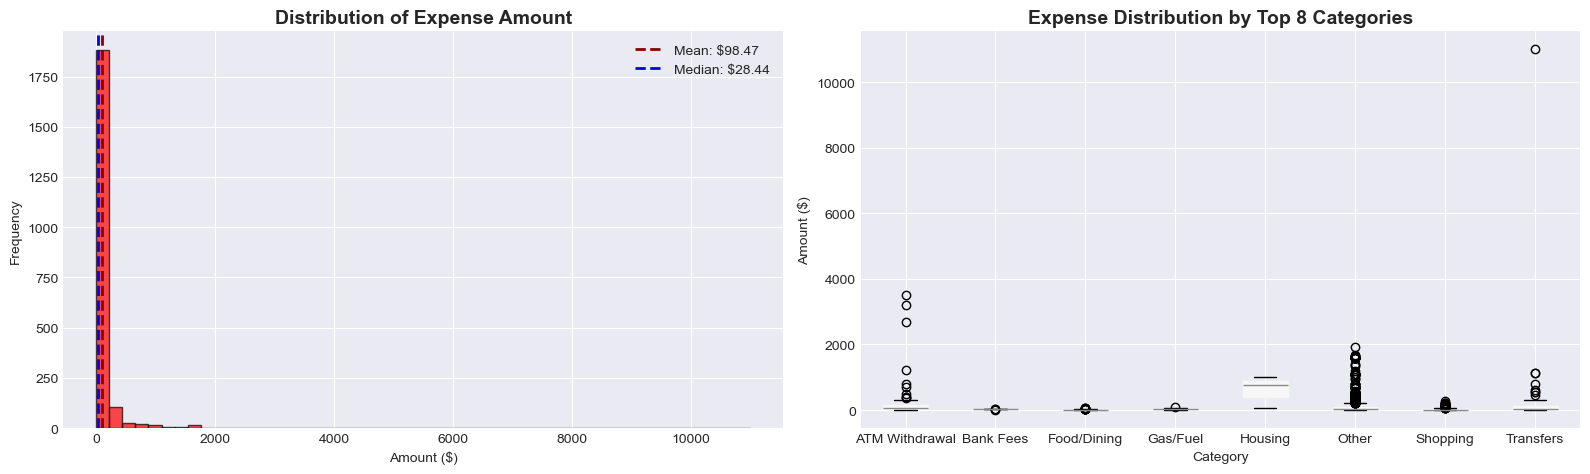

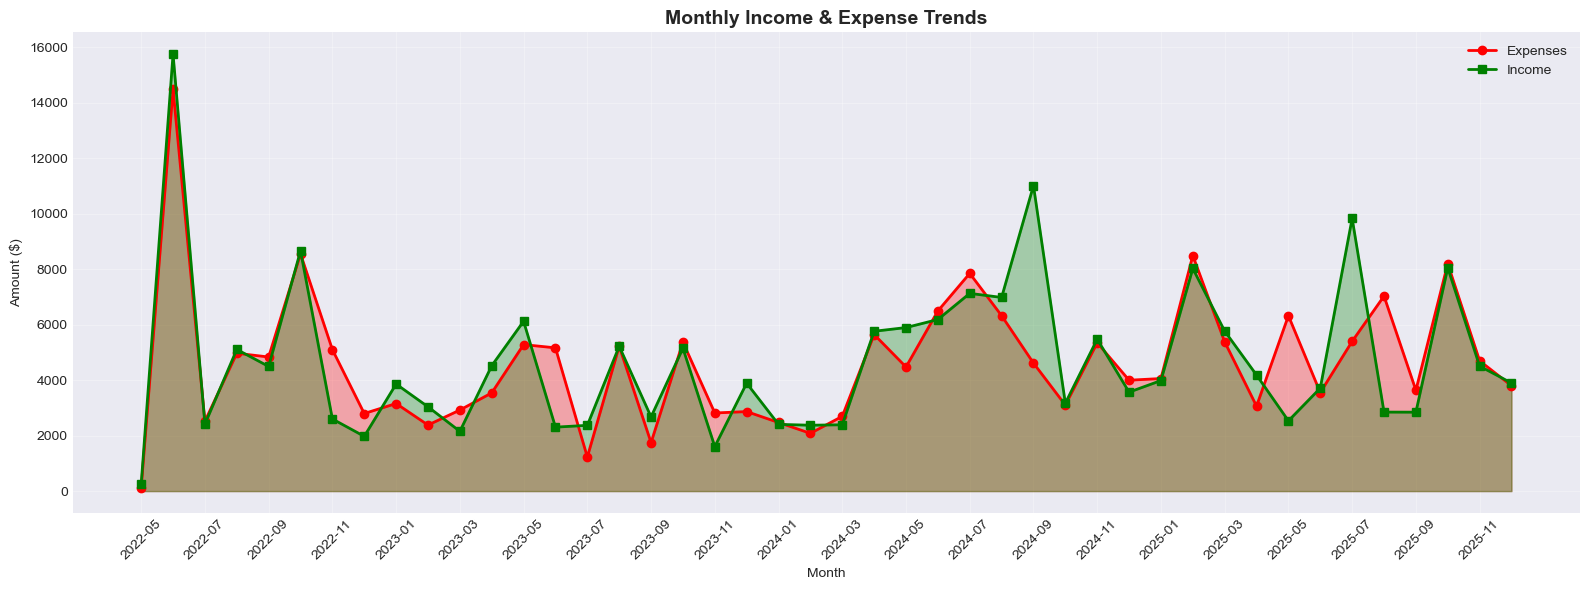

In [35]:
#Visualize the over all trend
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

#daily Balance overtime 
axes[0, 0].plot(df['date'], df['balance'], linewidth=1, alpha=0.7)
axes[0, 0].set_title('Account Balance Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Balance ($)')
axes[0, 0].grid(True, alpha=0.3)

#Monthly income vs Expenses
monthly_summary =df.groupby([df['date'].dt.to_period('M'), 'transaction_type'])['amount_abs'].sum().unstack(fill_value=0)
monthly_summary.plot(kind='bar', ax=axes[0, 1], color=['#ef4444', '#10b981'])
axes[0, 1].set_title('Monthly Income vs Expenses', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Amount ($)')
axes[0, 1].legend(['Expenses', 'Income'])
axes[0, 1].tick_params(axis='x', rotation=45)

#Category breakdown
category_totals = expenses.groupby('category') ['amount_abs'].sum().sort_values(ascending=False)
category_totals.plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Totoal Spending by Category', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Amount ($)')

#Days of Week Spending 
dow_spending = expenses.groupby('day_name') ['amount_abs'].mean().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])
dow_spending.plot(kind='bar', ax=axes[1, 1], color='skyblue')
axes[1, 1].set_title('Average Daily Spending by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day')
axes[1, 1].set_ylabel('Average Spending ($)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#Transaction Distribution
fig, axes = plt.subplots(1, 2, figsize=(16,5))

#DIstriution of Transactioin amount 
axes[0].hist(expenses['amount_abs'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[0].set_title('Distribution of Expense Amount', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Amount ($)'),
axes[0].set_ylabel('Frequency')
axes[0].axvline(expenses['amount_abs'].mean(), color='darkred', linestyle='--', linewidth=2, label=f"Mean: ${expenses['amount_abs'].mean():.2f}")
axes[0].axvline(expenses['amount_abs'].median(), color='blue', linestyle='--', linewidth=2, label=f"Median: ${expenses['amount_abs'].median():.2f}")
axes[0].legend()

# Box plot by category
top_categories = expenses.groupby('category')['amount_abs'].sum().nlargest(8).index
expenses[expenses['category'].isin(top_categories)].boxplot(
    column='amount_abs', by='category', ax=axes[1], patch_artist=True
)
axes[1].set_title('Expense Distribution by Top 8 Categories', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Amount ($)')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

# %% Time Series Analysis
# Monthly spending trend
monthly_expenses = expenses.groupby(df['date'].dt.to_period('M'))['amount_abs'].sum()
monthly_income = income.groupby(df['date'].dt.to_period('M'))['amount'].sum()

fig, ax = plt.subplots(figsize=(16, 6))
x = range(len(monthly_expenses))
ax.plot(x, monthly_expenses.values, marker='o', linewidth=2, label='Expenses', color='red')
ax.plot(x, monthly_income.values, marker='s', linewidth=2, label='Income', color='green')
ax.fill_between(x, monthly_expenses.values, alpha=0.3, color='red')
ax.fill_between(x, monthly_income.values, alpha=0.3, color='green')
ax.set_xticks(x[::2])
ax.set_xticklabels([str(m) for m in monthly_expenses.index[::2]], rotation=45)
ax.set_title('Monthly Income & Expense Trends', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Amount ($)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Section 1
Time-series analysis of account balances reveals high volatility and limited cash buffering despite a positive net cash flow. Monthly income and expenses closely track one another, indicating a tightly balanced financial profile. Category-level analysis shows that a substantial portion of spending falls into an uncategorized “Other” group, highlighting opportunities for improved classification. Day-of-week analysis indicates routine-driven spending patterns concentrated mid-week, suggesting temporal structure suitable for forecasting and anomaly detection models

### Section 2
Expense amounts exhibit a strongly right-skewed distribution, with a median transaction of $28.44 and rare but significant outliers exceeding $10K. Category-level analysis reveals stable, low-variance spending in routine categories such as food and fuel, contrasted with high-variance, event-driven categories including housing, transfers, and uncategorized expenses. These characteristics motivate the use of robust statistics, log-scaled features, and category-specific modeling strategies

### Section 3
Monthly income and expenses exhibit strong co-movement with frequent crossovers, indicating a tightly balanced cash-flow profile. Income is characterized by irregular spikes rather than consistent periodicity, while expenses closely follow income levels, suggesting responsive spending behavior. Although the account remains marginally cash-flow positive overall, surplus months are not consistently retained, limiting long-term balance growth and increasing sensitivity to income volatility.

# Machine Learning Models
### Goals: 
1. Anomaly Dectection to find unusual expenses
2. Develop Financial Profile 
3. Develop Personalized Financial Recommendation System toward better Financail Stability

#### ******************* END OF EXPLORATORY ANALYSIS **************** MOVE TO FEATURE ENGINEERING NOTE BOOK **********